In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATASCI 3000 Lab/2023_nba_player_stats.csv")
df.head()

# Data Cleaning and Preprocessing
# df.rename(columns={
#     'PTS': 'Game_Points',  # Points scored in a specific game
#     'Min': 'Minutes_Played',
#     'FG%': 'Field_Goal_Percentage',
#     '3P%': 'Three_Point_FG_Percentage',
#     'FT%': 'Free_Throw_Percentage',
#     'Opponent': 'Opponent_Team',  # Game-specific feature
#     'Home/Away': 'Game_Location'  # Game-specific feature
# }, inplace=True)

# Handle missing data
df['POS'].fillna('SG', inplace=True)
df.dropna(inplace=True)

# Log Transformation for non-linear relationships
df['Minutes_Played_Log'] = np.log1p(df['Min'])
df['Games_Played_Log'] = np.log1p(df['GP'])

# Remove unrealistic values for shooting percentages
df = df[(df['FG%'] > 30) & (df['FG%'] <= 70)]  # Typical FG% ranges from 30% to 70%
df = df[(df['3P%'] >= 25) & (df['3P%'] <= 50)]  # Typical 3P% ranges from 25% to 50%
df = df[(df['FT%'] >= 50) & (df['FT%'] <= 95)]  # FT% typically ranges from 50% to 95%

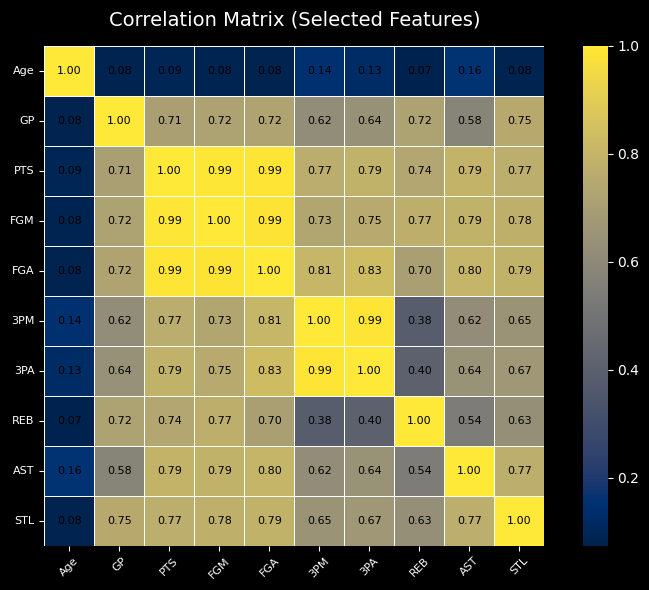

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features
relevant_features = [
    'Age', 'GP', 'PTS', 'FGM', 'FGA', '3PM', '3PA', 'REB', 'AST', 'STL'
]  # Update these based on actual column names
filtered_df = df[relevant_features]  # Ensure these exist in the dataset

# Compute the correlation matrix
correlation_matrix = filtered_df.corr()

# Set a dark background theme
plt.style.use('dark_background')

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjusted to a smaller size
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="cividis",  # Darker color palette for visibility
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8, "color": "black"},  # Black annotation text for visibility
    xticklabels=relevant_features,
    yticklabels=relevant_features
)

# Styling the heatmap
plt.title("Correlation Matrix (Selected Features)", fontsize=14, color='white', pad=15)
plt.xticks(fontsize=8, color='white', rotation=45)
plt.yticks(fontsize=8, color='white', rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

# Drop highly correlated or redundant columns
columns_to_drop = [
    'PName', 'Position', 'Team_Abbreviation', 'Field_Goals_Made', 'Field_Goals_Attempted',
    'Three_Point_FG_Made', 'Three_Point_FG_Attempted', 'NBA_Fantasy_Points', 'Double_Doubles',
    'Free_Throws_Attempted', 'Triple_Doubles', 'Offensive_Rebounds', 'Defensive_Rebounds'
]

# Drop only the columns that exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_columns_to_drop, inplace=True)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


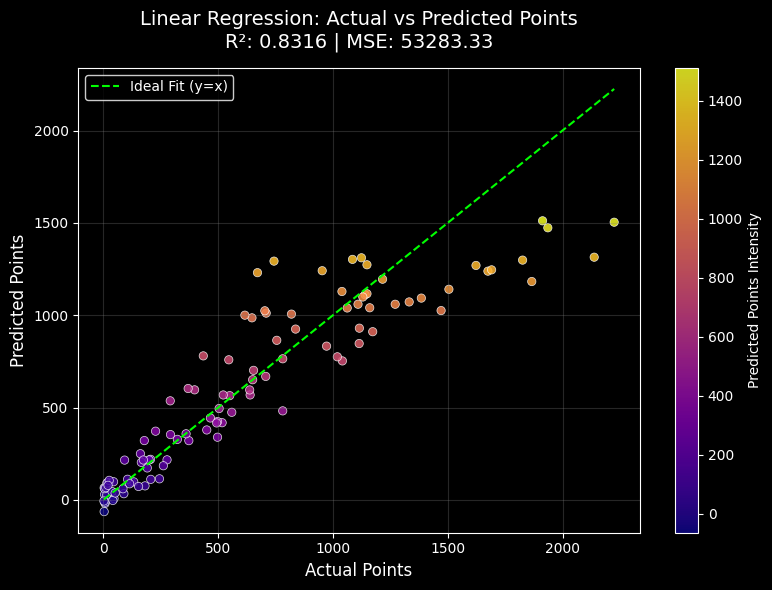

Linear Regression R2 Score: 0.8316
Linear Regression Mean Squared Error: 53283.3275


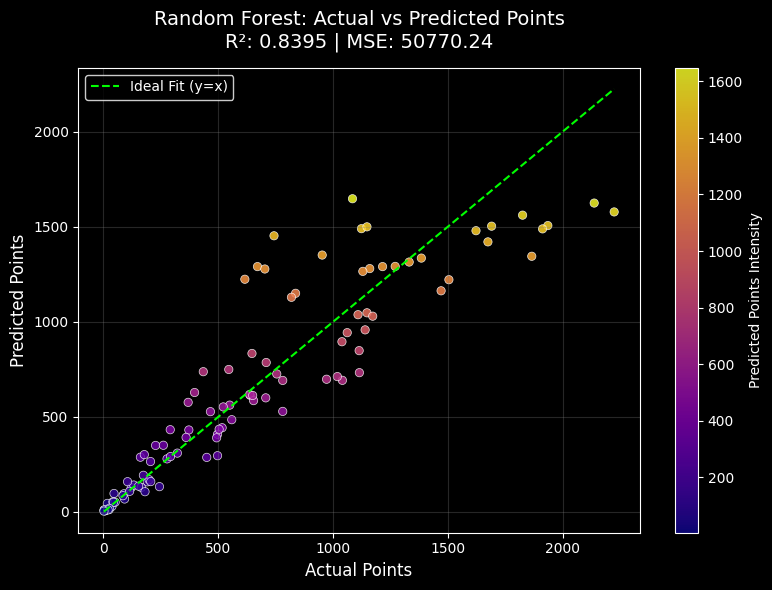

Random Forest R2 Score: 0.8395
Random Forest Mean Squared Error: 50770.2446


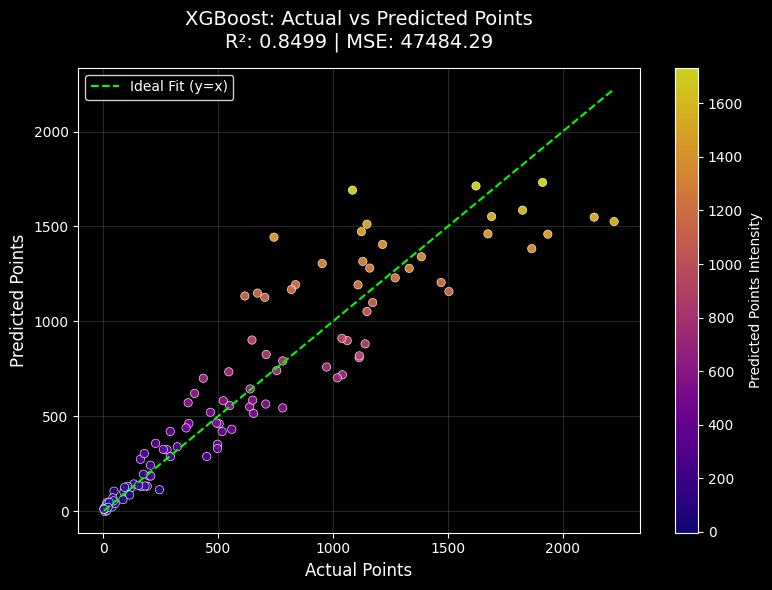

XGBoost R2 Score: 0.8499
XGBoost Mean Squared Error: 47484.2934


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# Select features and target
features = ['Min', 'GP', 'FG%', '3P%', 'FT%']
target = 'PTS'

# Extract the features and target from the DataFrame
X = df[features]  # Use the DataFrame 'df' to select features
y = df[target]    # Use the DataFrame 'df' to select the target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# Train and evaluate models
best_models = {}
for model_name, model in models.items():
    if model_name in param_grids:
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='r2', verbose=1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best {model_name} Parameters: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[model_name] = model

# Evaluate the models with enhanced scatter plots
plt.style.use('dark_background')  # Set dark theme
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Enhanced scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        y_test, y_pred,
        c=y_pred, cmap='plasma', alpha=0.85, edgecolor='white', linewidth=0.5
    )
    plt.colorbar(scatter, label='Predicted Points Intensity', orientation='vertical')
    plt.plot(
        [min(y_test), max(y_test)], [min(y_test), max(y_test)],
        'lime', linestyle='--', label='Ideal Fit (y=x)', linewidth=1.5
    )
    plt.title(
        f"{model_name}: Actual vs Predicted Points\nR²: {r2:.4f} | MSE: {mse:.2f}",
        fontsize=14, color='white', pad=15
    )
    plt.xlabel("Actual Points", fontsize=12, color='white')
    plt.ylabel("Predicted Points", fontsize=12, color='white')
    plt.legend(fontsize=10, facecolor='black', edgecolor='white')
    plt.grid(alpha=0.3, color='gray')
    plt.tight_layout()
    plt.show()

    print(f"{model_name} R2 Score: {r2:.4f}")
    print(f"{model_name} Mean Squared Error: {mse:.4f}")

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

for model_name, model in best_models.items():
    if model_name in ['Random Forest', 'XGBoost']:
        feature_importance = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
        importance_df.sort_values(by='Importance', ascending=True, inplace=True)  # Sort for horizontal bars

        """
        # Set dark background
        plt.style.use('dark_background')

        # Horizontal bar chart
        plt.figure(figsize=(8, 5))  # Smaller size for better fit
        sns.barplot(
            data=importance_df,
            x='Importance',
            y='Feature',
            palette='magma',  # Vibrant color palette suitable for dark themes
            edgecolor='black'
        )

        # Add value labels to bars
        for index, row in enumerate(importance_df.itertuples()):
            plt.text(
                row.Importance + 0.01, index, f"{row.Importance:.2f}",
                va='center', ha='left', fontsize=10, color='white'
            )

        # Styling
        plt.title(f'{model_name} Feature Importance', fontsize=14, color='white', pad=15)
        plt.xlabel('Importance', fontsize=12, color='white')
        plt.ylabel('Feature', fontsize=12, color='white')
        plt.xticks(fontsize=10, color='white')
        plt.yticks(fontsize=10, color='white')
        plt.grid(alpha=0.2, color='gray', linestyle='--')
        plt.tight_layout()
        plt.show()
        """

# Define the best Random Forest model for visualizations
best_RFRmodel = best_models['Random Forest']

# Visual comparison of predicted vs actual points
y_final = best_RFRmodel.predict(X)
comparison_df = pd.DataFrame({'Actual': y, 'Predicted': y_final})

# Scatter plot (Comparison of Actual vs. Predicted)
fig_scatter = px.scatter(
    comparison_df,
    x='Actual',
    y='Predicted',
    color='Actual',
    template='plotly_dark',
    title='Comparison of Actual vs. Predicted',
    labels={'Actual': 'Actual Points', 'Predicted': 'Predicted Points'},
    color_continuous_scale=px.colors.sequential.Plasma  # Dark theme-appropriate color scale
)
fig_scatter.update_traces(marker=dict(size=4, opacity=0.8))  # Smaller marker size
fig_scatter.update_layout(
    title=dict(font=dict(size=14)),  # Smaller title font
    margin=dict(l=30, r=30, t=50, b=30),  # Reduced margins
    width=700,  # Adjust width
    height=400   # Adjust height
)
fig_scatter.show()

# Histogram (Distribution of Actual and Predicted Points)
fig_hist = px.histogram(
    comparison_df,
    x=['Actual', 'Predicted'],
    nbins=30,
    barmode='overlay',
    template='plotly_dark',
    title='Distribution of Actual and Predicted Points',
    labels={'value': 'Points', 'variable': 'Values'},
    color_discrete_sequence=['#2E91E5', '#E15F99']  # Updated to match dark theme
)
fig_hist.update_layout(
    title=dict(font=dict(size=14)),  # Smaller title font
    margin=dict(l=30, r=30, t=50, b=30),  # Reduced margins
    width=700,  # Adjust width
    height=400   # Adjust height
)
fig_hist.show()

# Residual plot
residuals = y - y_final
fig_residual = go.Figure()
fig_residual.add_trace(
    go.Scatter(
        x=y_final,
        y=residuals,
        mode='markers',
        marker=dict(color='orangered', size=4, opacity=0.8),  # Smaller marker size
        showlegend=False
    )
)
fig_residual.add_shape(
    go.layout.Shape(
        type='line',
        x0=min(y_final),
        x1=max(y_final),
        y0=0,
        y1=0,
        line=dict(color='orange', dash='dash')
    )
)
fig_residual.update_layout(
    template='plotly_dark',
    title='Residual Plot',
    xaxis_title='Predicted Values',
    yaxis_title='Residuals',
    title_font=dict(size=14),  # Smaller title font
    margin=dict(l=30, r=30, t=50, b=30),  # Reduced margins
    width=700,  # Adjust width
    height=400   # Adjust height
)
fig_residual.show()

# Regression line comparison
fig_line = go.Figure()
fig_line.add_trace(
    go.Scatter(
        x=y,
        y=y,
        mode='lines',
        line=dict(color='#00CC96', width=1.5),  # Thinner line
        name='Ideal Line'
    )
)
fig_line.add_trace(
    go.Scatter(
        x=y,
        y=y_final,
        mode='markers',
        marker=dict(color='#636EFA', size=4, opacity=0.8),  # Smaller marker size
        name='Predicted Values'
    )
)
fig_line.add_trace(
    go.Scatter(
        x=np.unique(y),
        y=np.poly1d(np.polyfit(y, y_final, 1))(np.unique(y)),
        mode='lines',
        line=dict(color='#FECB52', dash='dot', width=1.5),  # Thinner line
        name='Regression Line'
    )
)
fig_line.update_layout(
    template='plotly_dark',
    title='Predicted vs. True Line Plot',
    xaxis_title='True Values',
    yaxis_title='Predicted Values',
    title_font=dict(size=14),  # Smaller title font
    margin=dict(l=30, r=30, t=50, b=30),  # Reduced margins
    width=700,  # Adjust width
    height=400   # Adjust height
)
fig_line.show()

In [45]:
# Predict totals and thresholds with visualization
def predict_totals_and_thresholds_visualized(player_name):
    player_data = df[df[player_name_column] == player_name]

    if player_data.empty:
        print(f"Player '{player_name}' not found in the dataset.")
        return

    player_features = player_data[features].iloc[-1].values.reshape(1, -1)
    totals = {}
    thresholds = []

    # Predict totals
    for metric, data in regressors.items():
        reg = data['model']
        predicted_total = reg.predict(player_features)[0]
        totals[metric] = predicted_total

    # Predict thresholds
    for metric, data in classifiers.items():
        clf = data['model']
        X_test = data['X_test']
        y_test = data['y_test']

        prob = clf.predict_proba(player_features)[0][1]
        pred_class = clf.predict(player_features)[0]

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        thresholds.append({
            'Metric': metric,
            'Likelihood (%)': f"{prob * 100:.2f}",
            'Prediction': 'Yes' if pred_class == 1 else 'No',
            'Accuracy (%)': f"{accuracy * 100:.2f}"
        })

    # Totals Table
    totals_df = pd.DataFrame(list(totals.items()), columns=['Metric', 'Predicted Value'])
    # print("\nPredicted Totals:")
    # print(tabulate(totals_df, headers='keys', tablefmt='pretty'))

    # Totals Visualization
    fig_totals = px.bar(
        totals_df,
        x='Metric',
        y='Predicted Value',
        title=f'{player_name} Predicted Totals',
        text='Predicted Value',
        template='plotly_dark'
    )
    fig_totals.update_traces(textposition='outside')
    fig_totals.update_layout(width=600, height=400)  # Smaller dimensions
    fig_totals.show()

    # Thresholds Table
    thresholds_df = pd.DataFrame(thresholds)
    # print("\nPredicted Thresholds:")
    # print(tabulate(thresholds_df, headers='keys', tablefmt='pretty'))

    # Thresholds Visualization
    fig_thresholds = px.bar(
        thresholds_df,
        x='Metric',
        y='Likelihood (%)',
        color='Prediction',
        title=f'{player_name} Predicted Thresholds',
        text='Likelihood (%)',
        template='plotly_dark'
    )
    fig_thresholds.update_traces(textposition='outside')
    fig_thresholds.update_layout(width=600, height=400)  # Smaller dimensions
    fig_thresholds.show()

# Evaluate models
def evaluate_models():
    classifier_results = []
    regressor_results = []

    for metric, data in classifiers.items():
        clf = data['model']
        X_test = data['X_test']
        y_test = data['y_test']
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classifier_results.append({'Metric': metric, 'Accuracy (%)': accuracy * 100})

    for metric, data in regressors.items():
        reg = data['model']
        X_test = data['X_test']
        y_test = data['y_test']
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        regressor_results.append({'Metric': metric, 'R2 Score': r2, 'MSE': mse})

    # Classifier Results
    classifier_df = pd.DataFrame(classifier_results)
    # print("\nClassifier Results:")
    # print(tabulate(classifier_df, headers='keys', tablefmt='pretty'))

    # Classifier Visualization
    fig_classifiers = px.bar(
        classifier_df,
        x='Metric',
        y='Accuracy (%)',
        title='Classifier Accuracy',
        template='plotly_dark',
        text='Accuracy (%)'
    )
    fig_classifiers.update_traces(textposition='outside')
    fig_classifiers.update_layout(width=600, height=400)  # Smaller dimensions
    fig_classifiers.show()

    # Regressor Results
    regressor_df = pd.DataFrame(regressor_results)
    # print("\nRegressor Results:")
    # print(tabulate(regressor_df, headers='keys', tablefmt='pretty'))

    # Regressor Visualization
    fig_regressors = px.bar(
        regressor_df,
        x='Metric',
        y='R2 Score',
        title='Regressor R² Scores',
        template='plotly_dark',
        text='R2 Score'
    )
    fig_regressors.update_traces(textposition='outside')
    fig_regressors.update_layout(width=600, height=400)  # Smaller dimensions
    fig_regressors.show()

# Example Usage
player_name_input = "LeBron James"  # Replace with a player from your dataset
predict_totals_and_thresholds_visualized(player_name_input)
evaluate_models()